# Fourth CatLearn tutorial.

This tutorial is intended to give further intuition for Gaussian processes.

Like in tutorial 3, we set up a known underlying function with two training features and one output feature, we generate training and test data and calculate predictions and errors.

We will compare the results of linear ridge regression, Gaussian linear kernel regression and finally a Gaussian process with the usual squared exponential kernel.

In [26]:
# Import packages.
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from catlearn.preprocess.scaling import standardize, target_standardize
from catlearn.regression import GaussianProcess

In [27]:
# A known underlying function in two dimensions
def afunc(x):
    """2D linear function (plane)."""
    return 3. * x[:, 0] - 1. * x[:, 1] + 50.

In [28]:
# Setting up data.
# A number of training points in x.
train_points = 30
# Magnitude of the noise.
noise_magnitude = 0.3

# Randomly generate the training datapoints x.
train_d1 = 2 * (np.random.random_sample(train_points) - 0.5)
train_d2 = 2 * (np.random.random_sample(train_points) - 0.5)
train_x1, train_x2 = np.meshgrid(train_d1, train_d2)
train = np.hstack([np.vstack(train_d1), np.vstack(train_d2)])

# Each element in the list train can be referred to as a fingerprint.
# Call the underlying function to produce the target values.
target = np.array(afunc(train))

# Add random noise from a normal distribution to the target values.
for i in range(train_points):
    target[i] += noise_magnitude * np.random.normal()

# Generate test datapoints x.
test_points = 30
test1d = np.vstack(np.linspace(-1.5, 1.5, test_points))
test_x1, test_x2 = np.meshgrid(test1d, test1d)
test = np.hstack([np.vstack(test_x1.ravel()), np.vstack(test_x2.ravel())])

print(np.shape(train))
print(np.shape(test))
print(np.shape(target))

# Standardize the training and test data on the same scale.
std = standardize(train_matrix=train,
                  test_matrix=test)
# Standardize the training targets.
train_targets = target_standardize(target)
# Note that predictions will now be made on the standardized scale.

# plot predicted tstd * uncertainties intervals.
tstd = 2.

(30, 2)
(900, 2)
(30,)


The `tstd` variable specifies how many standard deviations we plot.

# Model example 1 - Gausian linear kernel regression.

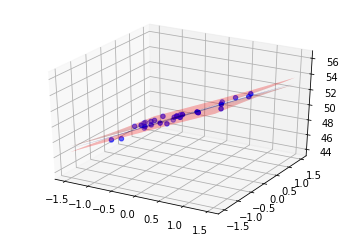

In [29]:
# Define prediction parameters
kdict = {'k1': {'type': 'linear', 'scaling': 1.},
         'c1': {'type': 'constant', 'const': 0.}}
# Starting guess for the noise parameter
sdt1 = noise_magnitude
# Set up the gaussian process.
gp1 = GaussianProcess(kernel_dict=kdict, regularization=sdt1,
                      train_fp=std['train'],
                      train_target=train_targets['target'],
                      optimize_hyperparameters=True)
# Do predictions.
linear = gp1.predict(test_fp=std['test'], uncertainty=True)
# Put predictions back on real scale.
prediction = np.vstack(linear['prediction']) * train_targets['std'] + \
    train_targets['mean']
# Put uncertainties back on real scale.
uncertainty = np.vstack(linear['uncertainty']) * train_targets['std']
# Get confidence interval on predictions.
over_upper = prediction + uncertainty * tstd
over_lower = prediction - uncertainty * tstd
# Plotting.
plt3d = plt.figure().gca(projection='3d')

# Plot training data.
plt3d.scatter(train[:, 0], train[:, 1], target,  color='b')

# Plot exact function.
plt3d.plot_surface(test_x1, test_x2,
                   afunc(test).reshape(np.shape(test_x1)),
                   alpha=0.3, color='b')
# Plot the uncertainties upper and lower bounds.
plt3d.plot_surface(test_x1, test_x2,
                   over_upper.reshape(np.shape(test_x1)),
                   alpha=0.3, color='r')
plt3d.plot_surface(test_x1, test_x2,
                   over_lower.reshape(np.shape(test_x1)),
                   alpha=0.3, color='r')

We see the upper and lower bounds of the confidence interval predicted by the linear model. It is fairly confident on even beyond the region of the training data set.

# Model example 2 - squared exponential kernel.

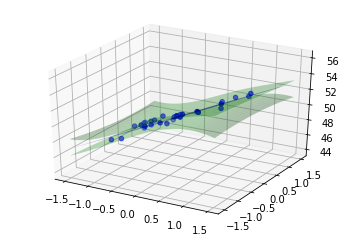

In [30]:
# Set up the prediction routine and optimize hyperparameters.
kdict = {'k1': {'type': 'gaussian', 'width': [0.3, 3.]}}
# Starting guess for the noise parameter
sdt1 = noise_magnitude
# Set up the gaussian process.
gp2 = GaussianProcess(kernel_dict=kdict, regularization=sdt1,
                      train_fp=std['train'],
                      train_target=train_targets['target'],
                      optimize_hyperparameters=True)
# Do the optimized predictions.
gaussian = gp2.predict(test_fp=std['test'], uncertainty=True)
# Put predictions back on real scale.
prediction = np.vstack(gaussian['prediction']) * train_targets['std'] + \
    train_targets['mean']
# Put uncertainties back on real scale.
uncertainty = np.vstack(gaussian['uncertainty']) * train_targets['std']
# Get confidence interval on predictions.
gp_upper = prediction + uncertainty * tstd
gp_lower = prediction - uncertainty * tstd
# Plotting.
plt3d = plt.figure().gca(projection='3d')

# Plot training data.
plt3d.scatter(train[:, 0], train[:, 1], target,  color='b')

# Plot exact function.
plt3d.plot_surface(test_x1, test_x2,
                   afunc(test).reshape(np.shape(test_x1)),
                   alpha=0.3, color='b')
# Plot the prediction.
plt3d.plot_surface(test_x1, test_x2,
                   gp_upper.reshape(np.shape(test_x1)),
                   alpha=0.3, color='g')
plt3d.plot_surface(test_x1, test_x2,
                   gp_lower.reshape(np.shape(test_x1)),
                   alpha=0.3, color='g')

Here we can see the confidence interval grows much faster, revealing that the squared exponential kernel is more uncertain outside the region of the training data.

### Experiment and get intuition.

Now, try playing around with the `train_points`, `noise_magnitude`  and `tstd` variables and rerun the models, to get a feel for the behavior of the Gaussian process and for viewing the various levels of confidence the two models can achieve. 